# Basic Model Testing

In [10]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [11]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [12]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [13]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [14]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [15]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [16]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

## Loading Full Dataset

In [17]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.94s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [18]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


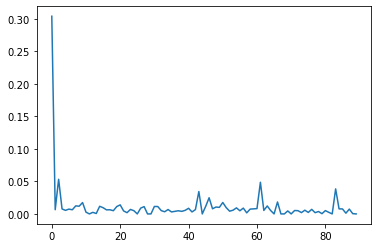

In [19]:
N=1024
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [20]:
all_Ids=valset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/val2017/'

5000


In [21]:
N=128
np.random.seed(0)
imgIds_perm=np.random.permutation(len(all_Ids))
tmp=imgIds_perm[0:N].astype(int)
tmp2=[all_Ids[t] for t in tmp]
valset.images=tmp2
valset.num_samples=len(valset.images)
np.random.seed(2)

In [33]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

## Dataloader

In [12]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [13]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [12]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [15]:
# regression on center point.
opt.arch = 'resdcn_18'
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [16]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [17]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [18]:
## Test for Using their train function from Ctdetrainer
# print('Starting training...')
# best = 1e10
# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
#     log_dict_train, _ = trainer.train(epoch, train_loader)
    

In [22]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [20]:
for name,param in model.named_parameters():
    if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
        print(param.size())
        print(torch.randn(param.size()))
    else:
        param.requires_grad=False

torch.Size([64, 64, 3, 3])
tensor([[[[ 1.1209e+00,  6.0275e-02,  3.7913e-01],
          [ 5.7623e-01, -9.1138e-01,  1.4473e-01],
          [-1.1200e-01,  3.4575e-01,  1.2922e+00]],

         [[ 5.8993e-01,  3.3910e-01,  5.9478e-01],
          [ 5.7137e-01,  3.7319e-01,  2.5294e-01],
          [-1.5675e+00,  1.2920e-01,  7.4774e-02]],

         [[-6.8727e-01,  1.1577e+00,  9.5753e-01],
          [ 4.4279e-01,  3.4859e-02, -4.2460e-01],
          [ 1.4776e+00,  5.1524e-01,  4.3300e-01]],

         ...,

         [[ 1.1134e-01,  2.6658e-01, -1.4957e+00],
          [ 2.7274e-01, -3.5664e-01, -2.0274e-01],
          [-4.8817e-01, -1.5175e+00, -1.6090e+00]],

         [[-2.6165e+00,  1.6923e-01,  4.1187e-01],
          [-1.1500e+00,  1.2118e-01, -9.5352e-01],
          [ 6.2534e-02,  1.3324e+00, -1.5629e+00]],

         [[ 9.6560e-01,  1.1630e+00, -1.9745e-01],
          [-1.3413e+00, -2.3307e+00, -4.4113e-01],
          [ 1.3185e+00, -1.6834e+00, -1.2366e+00]]],


        [[[ 5.9062e-01,  3

In [23]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param = torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [24]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [18]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model1);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

NameError: name 'model' is not defined

## Data Augmentation

0


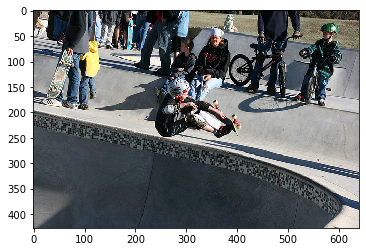

torch.Size([3, 512, 512]) (427, 640, 3)
1


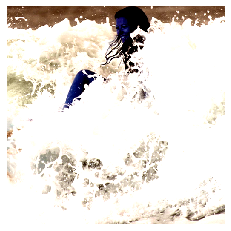

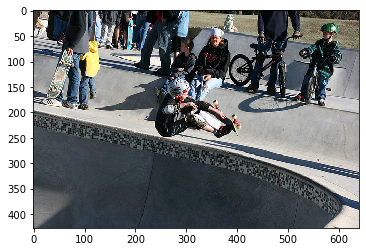

torch.Size([3, 512, 512]) (427, 640, 3)
2


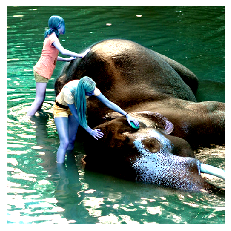

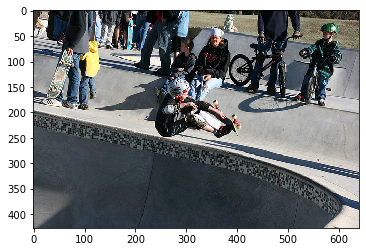

torch.Size([3, 512, 512]) (427, 640, 3)
3


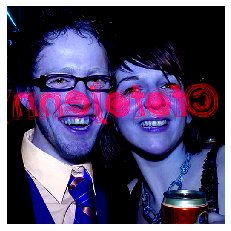

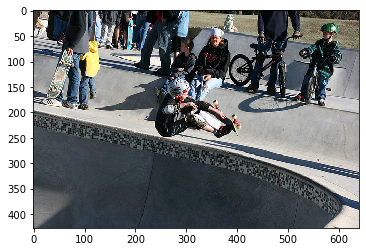

torch.Size([3, 512, 512]) (427, 640, 3)
4


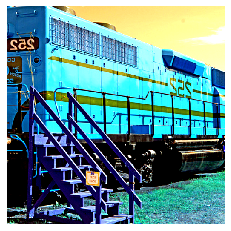

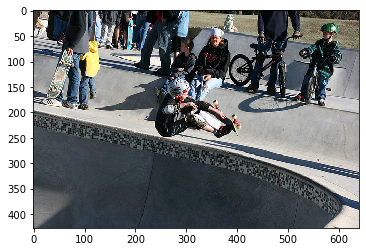

torch.Size([3, 512, 512]) (427, 640, 3)
5


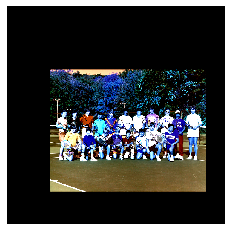

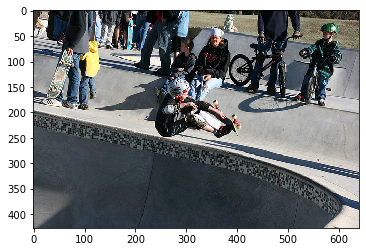

torch.Size([3, 512, 512]) (427, 640, 3)
6


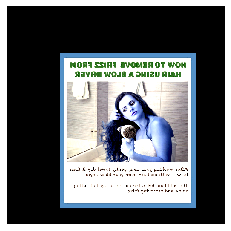

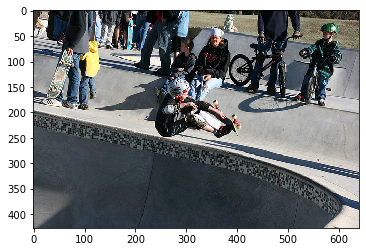

torch.Size([3, 512, 512]) (427, 640, 3)
7


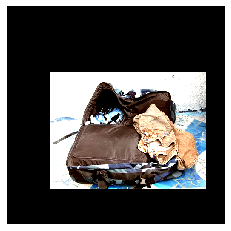

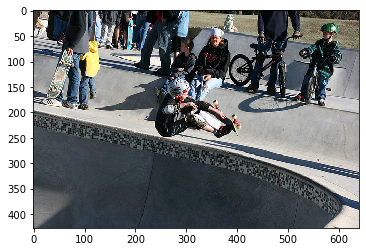

torch.Size([3, 512, 512]) (427, 640, 3)


KeyboardInterrupt: 

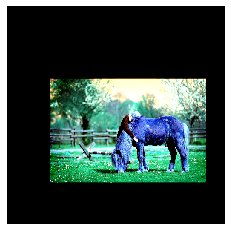

In [32]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    print(idx)
    x1=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x1[0,:,:,:])
    print(x1[0,:,:,:].shape,I.shape)

In [33]:
torch.equal(x,x1)
print()

NameError: name 'x' is not defined

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    x=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x[0,:,:,:])
    print(x[0,:,:,:].shape,I.shape)

## Manual Batch Loss computation

In [27]:
for idx,batch in enumerate(train_loader):
    #print(idx)
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=opt.device, non_blocking=True) 
    y=net.model(batch['input'])
    #y=net.model(batch['input'])
    #batch = batch.to(net.device)
    #y,_,_=net.model_with_loss(batch)
    #print(idx)
    loss1,_ = net.loss(y,batch)

NameError: name 'net' is not defined

In [ ]:
print(loss1.mean())

In [31]:
for name,param in net.model.named_parameters():
    print(name,param.size(),param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn1.weight torch.Size([64]) False
layer1.0.bn1.bias torch.Size([64]) False
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn2.weight torch.Size([64]) False
layer1.0.bn2.bias torch.Size([64]) False
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn1.weight torch.Size([64]) False
layer1.1.bn1.bias torch.Size([64]) False
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn2.weight torch.Size([64]) False
layer1.1.bn2.bias torch.Size([64]) False
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
layer2.0.bn1.weight torch.Size([128]) False
layer2.0.bn1.bias torch.Size([128]) False
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer2.0.bn2.weight torch.Size([128]) False
layer2.0.bn2.bias torch.Size([128]) False
layer2.0.downsample.0.weight torch.Size([128, 64

## Experiment with custom function run2

In [19]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="BaseExperiment", batch_size=opt.batch_size,perform_validation_during_training=False)

NameError: name 'net' is not defined

In [25]:
exp2.run2(num_epochs=5)

Start/Continue training from epoch 0
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size

torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128]) torch.Size([32, 2, 128, 128])
torch.Size([32, 2, 128, 128]) torch.Size

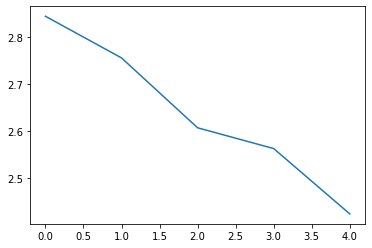

In [26]:
plt.plot(exp2.history)
plt.show()

### Pre-Trained model absolute value of Loss

In [25]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [26]:
model_pretrain = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer_pretrain = torch.optim.Adam(model_pretrain.parameters(), opt.lr)
model_pretrain =load_model(model_pretrain,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net_pretrain = Centernet_model(opt,model_pretrain);
net_pretrain = net_pretrain.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [27]:
adam_pretrain = torch.optim.Adam(net_pretrain.parameters(), lr=opt.lr)
stats_manager_pretrain = nt.StatsManager()
exp2 = nt.Experiment(net_pretrain,dataset,dataset,adam_pretrain,stats_manager_pretrain,
output_dir="BaseExperiment_PreTrain", batch_size=opt.batch_size,perform_validation_during_training=False)

In [23]:
exp2.evaluate2()

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


2.9636004106141627

In [24]:
exp2.stats_manager.number_update

256

### Changing wh_weight to 1

In [28]:
print('The default value for width-height loss weight is', opt.wh_weight)
opt.wh_weight = 1
print('The new value for width-height loss weight is', opt.wh_weight)

The default value for width-height loss weight is 0.1
The new value for width-height loss weight is 1


In [29]:
model_whwt = create_model(opt.arch, opt.heads, opt.head_conv) # wh-weight test
optimizer_whwt = torch.optim.Adam(model_whwt.parameters(), opt.lr)
model_whwt =load_model(model_whwt,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net_whwt = Centernet_model(opt,model_whwt);
net_whwt = net_whwt.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [30]:
adam_whwt = torch.optim.Adam(net_whwt.parameters(), lr=opt.lr)
stats_manager_whwt = nt.StatsManager()
exp_whwt = nt.Experiment(net_whwt,dataset,valset,adam_whwt,stats_manager_whwt,
output_dir="BaseExperiment__WHwt", batch_size=opt.batch_size,perform_validation_during_training=False)

In [34]:
exp_whwt.run2(num_epochs=100)

Start/Continue training from epoch 42
Epoch 43 (Time: 44.81s)
Epoch 44 (Time: 40.18s)
Epoch 45 (Time: 39.10s)
Epoch 46 (Time: 40.50s)


KeyboardInterrupt: 

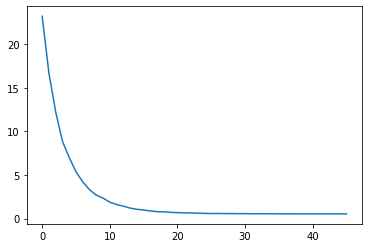

In [35]:
plt.plot(exp_whwt.history)
plt.show()

In [42]:
exp_whwt.history

[23.19815879315138,
 16.66849122568965,
 12.224816009402275,
 8.860405251383781,
 6.994718257337809,
 5.36864616535604,
 4.210261516273022,
 3.3093958171084523,
 2.6883604023605585,
 2.343873563222587,
 1.8833401449956,
 1.6132111116312444,
 1.419749468099326,
 1.2006702716462314,
 1.0601744493469596,
 0.9827106664888561,
 0.8668826634529978,
 0.7907412010245025,
 0.7707593685481697,
 0.7144769195001572,
 0.6834587610792369,
 0.6458060939330608,
 0.6433002804405987,
 0.6138359261676669,
 0.5960776682477444,
 0.5767089216969907,
 0.5819720972795039,
 0.5631255528423935,
 0.5732191081624478,
 0.5609697361942381,
 0.5626578838564456,
 0.5472601398359984,
 0.5537062846124172,
 0.5552208793815225,
 0.5442079168278724,
 0.5501975796651095,
 0.539662011899054,
 0.5435760717373341,
 0.5396517782937735,
 0.5381590495817363,
 0.5377337036188692,
 0.5324945598840714]

In [33]:
exp_whwt.evaluate2()

0.5826892800396308

In [36]:
exp_whwt.evaluate2()

0.5789077454246581

In [ ]:
exp_whwt.net.eval()
with torch.no_grad():
    for x, d in enumerate(exp_whwt.val_loader):
        for k in d:
            if k != 'meta':
                d[k] = d[k].to(device=exp_whwt.net.device, non_blocking=True)
        exp_whwt.optimizer.zero_grad()
        y = self.net.forward(d['input'])
        loss, _ = self.net.criterion(y, d)
        self.stats_manager.accumulate(loss.item(), x, y, d)
self.net.train()

In [111]:
valloader = td.DataLoader(valset, batch_size=1, shuffle=False, drop_last=True, pin_memory=True)

In [117]:
valset.

[397133,
 37777,
 252219,
 87038,
 174482,
 403385,
 6818,
 480985,
 458054,
 331352,
 296649,
 386912,
 502136,
 491497,
 184791,
 348881,
 289393,
 522713,
 181666,
 17627,
 143931,
 303818,
 463730,
 460347,
 322864,
 226111,
 153299,
 308394,
 456496,
 58636,
 41888,
 184321,
 565778,
 297343,
 336587,
 122745,
 219578,
 555705,
 443303,
 500663,
 418281,
 25560,
 403817,
 85329,
 329323,
 239274,
 286994,
 511321,
 314294,
 233771,
 475779,
 301867,
 312421,
 185250,
 356427,
 572517,
 270244,
 516316,
 125211,
 562121,
 360661,
 16228,
 382088,
 266409,
 430961,
 80671,
 577539,
 104612,
 476258,
 448365,
 35197,
 349860,
 180135,
 486438,
 400573,
 109798,
 370677,
 238866,
 369370,
 502737,
 515579,
 515445,
 173383,
 438862,
 180560,
 347693,
 39956,
 321214,
 474028,
 66523,
 355257,
 142092,
 63154,
 199551,
 239347,
 514508,
 473237,
 228144,
 206027,
 78915,
 551215,
 544519,
 96493,
 23899,
 340175,
 578500,
 366141,
 57597,
 559842,
 434230,
 428454,
 399462,
 261061,
 1

In [119]:
for k in valset[1]:
    print(k)

input
hm
reg_mask
ind
dense_wh
dense_wh_mask
reg
meta


In [70]:
valset.__getitem__(0)['input'].shape

(3, 512, 512)